In [1]:
import time
import biosppy
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import scipy
import warnings
warnings.filterwarnings('ignore')
from tqdm import tqdm 

from sliding.ecg_slider import ECGSlider
from sliding.slider import Slider
from statistic.wasserstein_distance import WassersteinDistance, WassersteinDistanceDeviation
from transform.indexed_transform import IndexedTransformer
from transform.interpolate import SplineInterpolate
from transform.pca import PCATransformer
from transform.scale import ScaleTransform
from transform.series_to_curve import CurveProjection, IndicesWindow
from transform.transformer import SequentialTransformer
from transform.triangle_pattern import TrianglePattern
from Bootstrap.wasserstein_bootstrap import wasserstein_computation
from func.Functions import chunkIt
from func.Functions import std_mean_change
from func.Functions import index_to_series
from func.Functions import annotations
from func.Functions import recall
from func.Functions import accuracy
from func.Functions import specifity
from func.Functions import  true_labels 
from func.Functions import  arrhythmia_index 
from func.Functions import  arrhythmia_index_check 

In [2]:
plt.rcParams["figure.figsize"] = (10, 5)
data=pd.read_csv('mitdb/205.csv')
mlii: pd.Series = data.iloc[:, 1]
sig_arr = np.asarray(mlii.tolist())
ECG_parts=chunkIt(sig_arr,5)
mlii_parts=chunkIt(mlii,5)
sig=ECG_parts[0]
mli=mlii_parts[0]

sig_series=pd.Series(sig)
sig_series.index=mli.index
projection_step = 1
smooth_transform = SequentialTransformer(
    ScaleTransform(0, 1),
    SplineInterpolate(0.02)
)


smooth_data = smooth_transform(sig)


from tqdm import tqdm 


#was,was_deviation_median,was_index,curves=wasserstein_computation(smooth_data,100,2,3,3)


In [3]:
was1,was_deviation_median1,was_index1,curves1=wasserstein_computation(smooth_data,100,2,3,4,10)

453it [05:52,  1.77it/s]Warning: numerical errors at iteration 279
455it [05:53,  1.97it/s]Warning: numerical errors at iteration 195
549it [07:05,  1.29it/s]


In [4]:
new_data=std_mean_change(was_deviation_median1,was1)
line=np.quantile(new_data,0.95)
sep_line1=[line]*len(smooth_data)

triangle = IndexedTransformer(TrianglePattern(7), padding=1, step=1)
tr_indices, tr_was = triangle(np.asarray(was1))
tr_indices_dev, tr_was_dev = triangle(np.asarray(new_data))
final_indices = np.asarray(was_index1)[tr_indices]

f_i_d=np.array([])
ind=np.array([])
for i,j in enumerate(tr_was):
    #if max(tr_was)>=min(tr_was):
    if j>line:
        f_i_d=np.append(j,f_i_d)
        ind=np.append(i,ind)
fin_ind=np.array([])
for i in ind:
    fin_ind=np.append(final_indices[int(i)],fin_ind)

f_i_d =f_i_d[::-1]

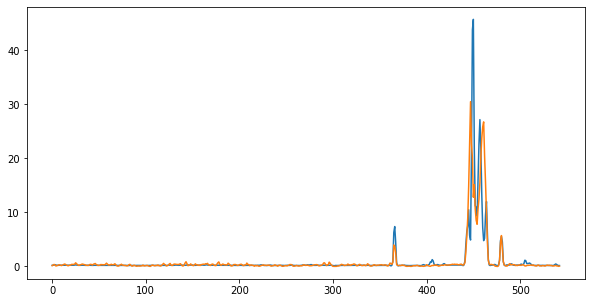

In [5]:
plt.plot(tr_was)
plt.plot(tr_was_dev)

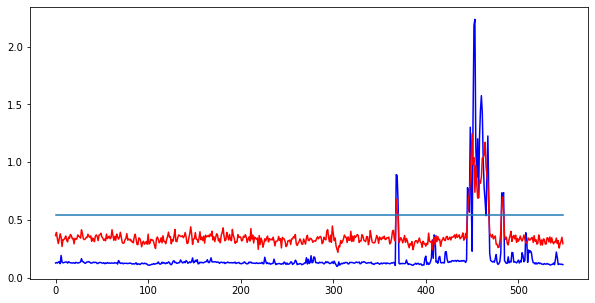

In [6]:
plt.plot(was1,c='b',label='was')
plt.plot(was_deviation_median1,c='r',label='deviation')
plt.plot([line]*len(new_data))

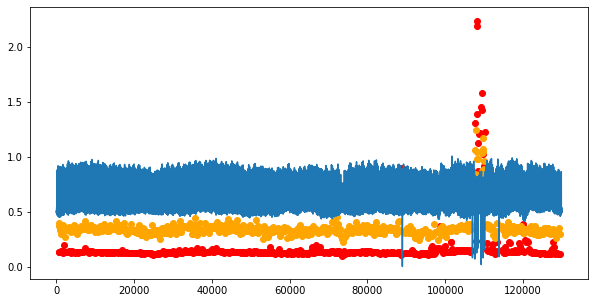

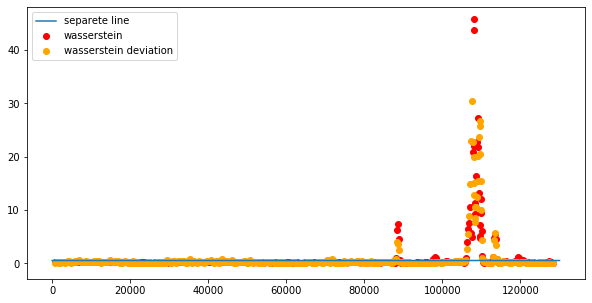

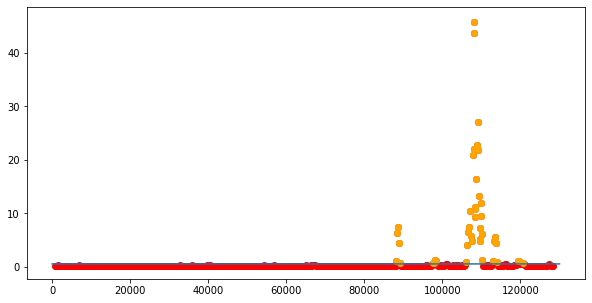

In [7]:
plt.plot(smooth_data)
plt.scatter(was_index1, was1, c="red")
plt.scatter(was_index1, was_deviation_median1, c="orange")
plt.show()

#plt.plot(smooth_data)
plt.scatter(final_indices, tr_was, c="red",label='wasserstein')
plt.scatter(final_indices, tr_was_dev, c="orange",label='wasserstein deviation')
plt.plot(sep_line1,label='separete line')
plt.legend()
plt.show()

#plt.plot(smooth_data)
plt.scatter(final_indices, tr_was, c="red")
plt.scatter(fin_ind, f_i_d, c="orange")
plt.plot(sep_line1)
#plt.scatter(fin_ind, f_i_d, c="orange")
plt.show()

In [8]:
fin_ind=fin_ind.astype(int)
data_arrhythmia,data_normal,rr=annotations(205)
T_labels=true_labels(data_arrhythmia,sig_series)

final_indices_ser=pd.Series(final_indices)
fin_ind_ser=pd.Series(fin_ind)
columns=[final_indices_ser,fin_ind_ser]
frame=pd.DataFrame(data=columns)
frame=frame.T
res=frame.loc[frame[0].isin(frame[1])]
indexes_arrhythmia_result=arrhythmia_index(res,sig_series,200)
indexes_arrhythmia_array_result=arrhythmia_index_check(res,sig_series,200)

result_series=index_to_series(indexes_arrhythmia_result,sig_series)

print('recall: ',recall(data_arrhythmia['sample'],indexes_arrhythmia_array_result,sig_series))
print('specifity: ',specifity(data_normal['sample'],indexes_arrhythmia_array_result,sig_series))

26 27
recall:  0.9629629629629629
specifity:  (0.9568480300187617, 510, 23)
